<a href="https://colab.research.google.com/github/ggoggori/Dacon/blob/main/%EC%9E%91%EB%AC%BC%20%EB%B3%91%ED%95%B4%EB%B6%84%EB%A5%98%20AI%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ./data
!unzip -uq "/content/drive/MyDrive/Colab Notebooks/데이콘/작물 병해 분류 AI 경진대회/235842_작물 병해 분류 AI 경진대회_data.zip" -d "./data"

mkdir: cannot create directory ‘./data’: File exists


In [ ]:
!pip install efficientnet_pytorch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
import os
import time
import datetime
import math
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')
from efficientnet_pytorch import EfficientNet
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
base_path = '/content/data'
train_df = pd.read_csv(os.path.join(base_path,'/content/data/train.csv'))
test = pd.read_csv(os.path.join(base_path,'/content/data/test.csv'))
sample_submission = pd.read_csv(os.path.join(base_path,'/content/data/sample_submission.csv'))

In [ ]:
class config:
    lr = 0.001
    batch_size = 16
    num_epochs = 100
    fold = 5
    model = 'efficientnet-b0'
    random_state = 4
    n_classes = 7
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    save_path = '/content/drive/MyDrive/Colab Notebooks/데이콘/작물 병해 분류 AI 경진대회/saved_model'

# simple_eda

In [ ]:
train.head()

,uid,img_path,disease,disease_code
0,10000,train_imgs/10000.jpg,시설포도노균병,1
1,10001,train_imgs/10001.jpg,시설포도노균병,1
2,10002,train_imgs/10002.jpg,시설포도노균병반응,2
3,10003,train_imgs/10003.jpg,축과병,4
4,10004,train_imgs/10004.jpg,시설포도노균병,1


정상           106
시설포도노균병       46
시설포도노균병반응     30
일소피해          29
축과병           17
시설포도탄저병       12
시설포도탄저병반응     10
Name: disease, dtype: int64
0    106
1     46
2     30
3     29
4     17
5     12
6     10
Name: disease_code, dtype: int64


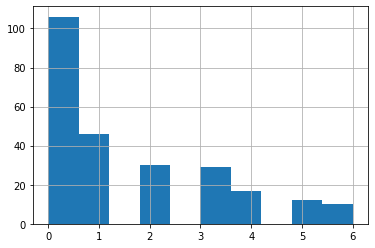

In [ ]:
print(train['disease'].value_counts())
print(train['disease_code'].value_counts())
train['disease_code'].hist()

In [ ]:
test.head()

,uid,img_path
0,20000,test_imgs/20000.jpg
1,20001,test_imgs/20001.jpg
2,20002,test_imgs/20002.jpg
3,20003,test_imgs/20003.jpg
4,20004,test_imgs/20004.jpg


In [ ]:
print('train_image 갯수:',len(os.listdir('/content/data/train_imgs')))
print('train_image 갯수:', len(os.listdir('/content/data/test_imgs')))

train_image 갯수: 251
train_image 갯수: 4751


542 278


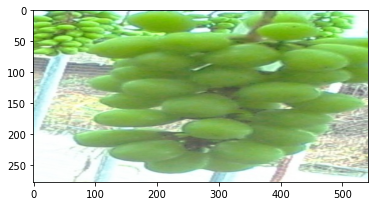

In [ ]:
image = PIL.Image.open('/content/data/train_imgs/10012.jpg')
plt.imshow(image)
print(image.width, image.height)

# dataset

In [ ]:
def make_planeset(train_idx, valid_idx):
    train_image_path = [os.path.join(base_path, path)for path in train_df['img_path'].values]
    test_image_path = [os.path.join(base_path, path)for path in test['img_path'].values]
    labels = train_df['disease_code'].values

    train_images = []
    for path in train_image_path:
        image = PIL.Image.open(path)    
        train_images.append(image)

    data = pd.DataFrame({'images':train_images,'labels':labels})

    train_images = data.loc[train_idx]['images'].values
    train_labels = data.loc[train_idx]['labels'].values
    valid_images = data.loc[valid_idx]['images'].values
    valid_labels = data.loc[valid_idx]['labels'].values

    return train_images, train_labels, valid_images, valid_labels, test_image_path

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, images, labels=None, mode='train', transforms=None):
        self.mode = mode
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            image = self.images[idx]
            label = self.labels[idx]
        else:
            image_path = self.images[idx]
            image = PIL.Image.open(image_path)

        if self.transforms is not None:
            image = self.transforms(image)

        if self.mode == 'train':
            batch = {'image':image, 'label':label}
        else:
            batch = {'image':image} 

        return batch

In [ ]:
train_transforms = transforms.Compose([
                                       transforms.Lambda(lambda x: transforms.RandomCrop(size=(int(x.height* 0.9), int(x.width *0.9)))(x)),
                                       transforms.RandomAffine(20),
                                       transforms.ColorJitter(brightness = (1,1.1)),
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# train

In [ ]:
def train(mode='train'):
    correct, losses = 0,0

    if mode == 'train':
        model.train()
        for iter, batch in enumerate(train_dataloader):
            image = batch['image'].to(config.device)
            label = batch['label'].to(config.device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                output = model(image)
                loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            _, pred = torch.max(output, 1)
            correct += (pred==label).sum()
            losses += loss.item()

        acc = round(correct.cpu().numpy()/len(train_dataset),5)

    elif 'valid':
        model.eval()
        for iter, batch in enumerate(valid_dataloader):
            image = batch['image'].to(config.device)
            label = batch['label'].to(config.device)
            with torch.no_grad():
                output = model(image)
                loss = criterion(output, label) 
                _, pred = torch.max(output, 1)
                correct += (pred==label).sum()
                losses += loss.item()
        acc = round(correct.cpu().numpy()/len(valid_dataset),5)

    return acc, losses

def inference():
    model.eval()
    results = []
    probability = []
    for batch in test_dataloader:
        image = batch['image'].to(config.device)
        with torch.no_grad():
            output = model(image)
        logit = torch.tensor(output)
        probs = torch.nn.functional.softmax(logit).cpu().numpy()
        output = torch.argmax(output, axis=-1).cpu().numpy()
        results.extend(output)
        probability.extend(probs)
        
    return results, np.array(probability)

In [ ]:
results = []
probability = []
sss = StratifiedShuffleSplit(n_splits=config.fold, test_size=.2, random_state=config.random_state)
indices = range(len(train_image_path))
labels = train_df['disease_code'].values

for fold, (train_index, valid_index) in enumerate(sss.split(indices, labels), 1):
    print('fold: {}'.format(fold))
    print('#'*40)
    train_images, train_labels, valid_images, valid_labels, test_image_path = make_planeset(train_index, valid_index)
    train_dataset = PlantDataset(train_images, train_labels, mode='train', transforms=train_transforms)
    valid_dataset = PlantDataset(valid_images, valid_labels, mode='train', transforms=test_transforms)
    test_dataset = PlantDataset(test_image_path, mode='test', transforms=test_transforms)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    model = EfficientNet.from_pretrained(config.model, num_classes=config.n_classes)
    model = model.to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss()
    best_val_metric, best_val_loss = 0, math.inf

    for epoch in range(0, config.num_epochs):
        start = time.time()
        train_acc, train_loss = train()
        valid_acc, valid_loss = train(mode='valid')

        print(f'[{epoch+1}]')
        print('[train] ACC:{} / loss:{}'.format(train_acc, train_loss))
        print('[valid] ACC:{} / loss:{}'.format(valid_acc, valid_loss))

        if valid_acc >= best_val_metric and valid_loss < best_val_loss:
            if valid_loss > train_loss:
                now = datetime.datetime.now()
                now = now.strftime('%Y-%m-%d %H:%M:%S')
                torch.save(model.state_dict(), os.path.join(config.save_path, '{}_model_weight.pt'.format(now)))
                best_val_metric = valid_acc
                best_val_loss = valid_loss
                print(f'model saved at {epoch+1} epoch {now}') 
            elif train_loss > valid_loss and train_loss - valid_loss < 0.1 :
                now = datetime.datetime.now()
                now = now.strftime('%Y-%m-%d %H:%M:%S')
                torch.save(model.state_dict(), os.path.join(config.save_path, '{}_model_weight.pt'.format(now)))
                best_val_metric = valid_acc
                best_val_loss = valid_loss
                print(f'model saved at {epoch+1} epoch {now}')  

        end = time.time() 
        print(f'--------------"{end - start:.5f} sec"-----------------')

    model.load_state_dict(torch.load(os.path.join(config.save_path, '{}_model_weight.pt'.format(now))))
    preds, probs = inference()
    results.append(preds)
    probability.append(probs)

fold: 1
########################################
Loaded pretrained weights for efficientnet-b0
[1]
[train] ACC:0.68 / loss:15.035693764686584
[valid] ACC:0.72 / loss:2.815697379410267
--------------"37.92460 sec"-----------------
[2]
[train] ACC:0.955 / loss:3.9282954782247543
[valid] ACC:0.92 / loss:0.7752122208476067
--------------"20.49027 sec"-----------------
[3]
[train] ACC:0.94 / loss:2.539866127073765
[valid] ACC:0.84 / loss:1.9854650392662734
--------------"20.86441 sec"-----------------
[4]
[train] ACC:0.985 / loss:0.8681693822145462
[valid] ACC:0.9 / loss:0.6348994009567832
--------------"20.56685 sec"-----------------
[5]
[train] ACC:0.995 / loss:0.699819028377533
[valid] ACC:0.96 / loss:0.4451723388010578
--------------"20.36963 sec"-----------------
[6]
[train] ACC:0.985 / loss:0.7742036357522011
[valid] ACC:0.96 / loss:0.712757455881615
model saved at 6 epoch 2021-10-21 17:16:51
--------------"20.48864 sec"-----------------
[7]
[train] ACC:0.965 / loss:2.500968277454376


In [ ]:
import pickle
with open(os.path.join(config.save_path,"results.pickle"),"wb") as fw:
    pickle.dump(results, fw)
with open(os.path.join(config.save_path,"probability.pickle"),"wb") as fw:
    pickle.dump(probability, fw)

In [ ]:
with open(os.path.join(config.save_path,"results.pickle"), 'rb') as f:
    results = pickle.load(f) 
with open(os.path.join(config.save_path,"probability.pickle"), 'rb') as f:
    probability = pickle.load(f) 

# ssl

In [ ]:
probs = np.sum(np.array(probability), axis=0)/5
preds = np.argmax(np.sum(np.array(probability), axis=0)/5, axis=1)
test['probs'] = np.max(probs, axis=1)
test['disease_code'] = preds
test = test[test['probs'] > 0.9]
train_df = pd.concat([train_df, test], axis=0)

In [ ]:
config.fold=3
config.num_epochs=80

In [ ]:
def make_planeset(train_idx, valid_idx):
    train_image_path = [os.path.join(base_path, path)for path in train_df['img_path'].values]
    test_image_path = [os.path.join(base_path, path)for path in test['img_path'].values]
    labels = train_df['disease_code'].values

    data = pd.DataFrame({'images':train_image_path,'labels':labels})

    train_images_path = data.loc[train_idx]['images'].values
    train_labels = data.loc[train_idx]['labels'].values
    valid_images_path = data.loc[valid_idx]['images'].values
    valid_labels = data.loc[valid_idx]['labels'].values

    return train_images_path, train_labels, valid_images_path, valid_labels, test_image_path

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, images, labels=None, mode='train', transforms=None):
        self.mode = mode
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            image_path = self.images[idx]
            image = PIL.Image.open(image_path)
            label = self.labels[idx]
        else:
            image_path = self.images[idx]
            image = PIL.Image.open(image_path)

        if self.transforms is not None:
            image = self.transforms(image)

        if self.mode == 'train':
            batch = {'image':image, 'label':label}
        else:
            batch = {'image':image} 

        return batch

In [ ]:
results = []
probability = []
sss = StratifiedShuffleSplit(n_splits=config.fold, test_size=.2, random_state=config.random_state)
indices = range(train_df.shape[0])
labels = train_df['disease_code'].values

for fold, (train_index, valid_index) in enumerate(sss.split(indices, labels), 1):
    print('fold: {}'.format(fold))
    print('#'*40)
    train_images, train_labels, valid_images, valid_labels, test_image_path = make_planeset(train_index, valid_index)
    train_dataset = PlantDataset(train_images, train_labels, mode='train', transforms=train_transforms)
    valid_dataset = PlantDataset(valid_images, valid_labels, mode='train', transforms=test_transforms)
    test_dataset = PlantDataset(test_image_path, mode='test', transforms=test_transforms)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    model = EfficientNet.from_pretrained(config.model, num_classes=config.n_classes)
    model = model.to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss()
    best_val_metric, best_val_loss = 0, math.inf

    for epoch in range(0, config.num_epochs):
        start = time.time()
        train_acc, train_loss = train()
        valid_acc, valid_loss = train(mode='valid')

        print(f'[{epoch+1}]')
        print('[train] ACC:{} / loss:{}'.format(train_acc, train_loss))
        print('[valid] ACC:{} / loss:{}'.format(valid_acc, valid_loss))

        if valid_acc >= best_val_metric and valid_loss < best_val_loss:
            if valid_loss > train_loss:
                now = datetime.datetime.now()
                now = now.strftime('%Y-%m-%d %H:%M:%S')
                torch.save(model.state_dict(), os.path.join(config.save_path, '{}_model_weight.pt'.format(now)))
                best_val_metric = valid_acc
                best_val_loss = valid_loss
                print(f'model saved at {epoch+1} epoch {now}') 
            elif train_loss > valid_loss and train_loss - valid_loss < 0.1 :
                now = datetime.datetime.now()
                now = now.strftime('%Y-%m-%d %H:%M:%S')
                torch.save(model.state_dict(), os.path.join(config.save_path, '{}_model_weight.pt'.format(now)))
                best_val_metric = valid_acc
                best_val_loss = valid_loss
                print(f'model saved at {epoch+1} epoch {now}')  

        end = time.time() 
        print(f'--------------"{end - start:.5f} sec"-----------------')

    model.load_state_dict(torch.load(os.path.join(config.save_path, '{}_model_weight.pt'.format(now))))
    preds, probs = inference()
    results.append(preds)
    probability.append(probs)

fold: 1
########################################
Loaded pretrained weights for efficientnet-b0
[1]
[train] ACC:0.93335 / loss:48.882872089743614
[valid] ACC:0.94743 / loss:13.545388465834549
--------------"622.82288 sec"-----------------
[2]
[train] ACC:0.97369 / loss:18.013639360666275
[valid] ACC:0.9965 / loss:0.965774042517296
--------------"618.68816 sec"-----------------
[3]
[train] ACC:0.97895 / loss:12.011066870763898
[valid] ACC:0.99883 / loss:0.9466411949078974
--------------"625.58079 sec"-----------------
[4]
[train] ACC:0.99357 / loss:4.896594926714897
[valid] ACC:0.99883 / loss:0.43567187613598435
--------------"620.32400 sec"-----------------
[5]
[train] ACC:0.98655 / loss:8.739836281863973
[valid] ACC:0.9965 / loss:0.8941925042363437
--------------"619.82483 sec"-----------------
[6]
[train] ACC:0.98772 / loss:8.857210190268233
[valid] ACC:0.99533 / loss:1.77996499931578
--------------"614.42575 sec"-----------------
[7]
[train] ACC:0.98129 / loss:11.393764108419418
[val

KeyboardInterrupt: ignored

In [ ]:
preds, probs = inference()

In [ ]:
test

,uid,img_path,probs,disease_code
0,20000,test_imgs/20000.jpg,0.986579,5
1,20001,test_imgs/20001.jpg,0.999643,1
2,20002,test_imgs/20002.jpg,0.999991,0
3,20003,test_imgs/20003.jpg,0.917975,0
4,20004,test_imgs/20004.jpg,0.999919,2
...,...,...,...,...
4745,24745,test_imgs/24745.jpg,0.999877,0
4746,24746,test_imgs/24746.jpg,0.999265,0
4747,24747,test_imgs/24747.jpg,0.999971,0
4748,24748,test_imgs/24748.jpg,0.999573,1


# inference

In [ ]:
test = pd.read_csv(os.path.join(base_path,'/content/data/test.csv'))

In [ ]:
train_images, train_labels, valid_images, valid_labels, test_image_path = make_planeset(train_index, valid_index)
test_dataset = PlantDataset(test_image_path, mode='test', transforms=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

In [ ]:
preds, probs = inference()

In [ ]:
#pred = np.argmax(np.sum(np.array(probability), axis=0)/5, axis=1)

In [ ]:
sample_submission = pd.read_csv(os.path.join(base_path,'/content/data/sample_submission.csv'))

In [ ]:
sample_submission.iloc[:,1] = preds

In [ ]:
sample_submission

,uid,disease_code
0,20000,5
1,20001,1
2,20002,0
3,20003,0
4,20004,2
...,...,...
4745,24745,0
4746,24746,0
4747,24747,0
4748,24748,1


In [ ]:
sample_submission.to_csv('baseline.csv', index=False)

In [ ]:
from google.colab import files

files.download('baseline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>